# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

##[Feedback]
심화과제라서 데이터셋이 CIFAR10 바뀌지고, 다음번 강의가 CNN을 넘기고
바로 RNN 으로 간다고 들어서,  ANN 대신 CNN 으로 구현을 해보려고 했습니다.  

진행과정에 문제들이 많이 발생하여 해결하는데 시간을 많이 소비를 했었고,
다시 ANN 모델로 기본과제 토대로 진행하려다 시간문제로 일단 이데로 올립니다.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import SGD
import numpy as np

#[Feedback]
저의 환경 세팅의 GPU 문제가 있어 해결이 되지 않아 cpu를 쓰게 되였습니다. 환경문제 별도로 문의드리겠습니다.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:05<00:00, 33.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


[Feedback]
어떤 데이터셋인지 이미지를 확인해보았습니다.

50000
torch.Size([3, 32, 32]) 6


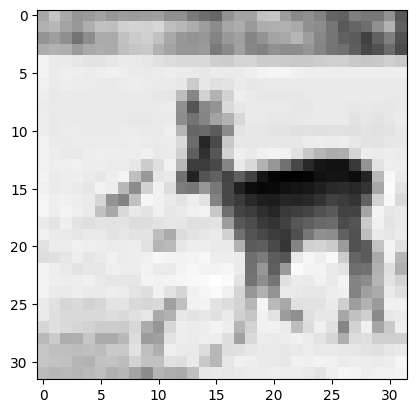

In [4]:
from matplotlib import pyplot as plt
print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[20][0][0], cmap='gray')

In [5]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

##[Feedback]
data 모양을 내다보는 코드,  그런데,  채널 과 Dimension 같은 개념인지 햇갈립니다.  
예를 들어 torch.Size([256, 3, 32, 32])   3 은 RGB 체널이자 3 Dim 이라고 하는거죠?

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

##[My code]
Activation Sigmoid 와 Relu 비교하기 위한 모델 초기화, Leaky_Relu 로 디폴드 생성

In [7]:
from torch import nn

class SimpleCNN(nn.Module):
     def __init__(self, act_type):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 입력 채널 3, 출력 채널 32, 커널 크기 3x3
        self.pool = nn.MaxPool2d(2, 2)               # 풀링 크기 2x2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 입력 채널 32, 출력 채널 64, 커널 크기 3x3
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)        # 완전 연결 층
        self.fc2 = nn.Linear(512, 10)                # 출력 층 (10개의 클래스)
        self.act_type = act_type                     # 모델 activation parameter

        print("act_type:",act_type)
     def forward(self, x):

        # Layer 1 tensor + activation + pool
        x = self.conv1(x)
        if self.act_type == "Sigmoid":
            x = torch.sigmoid(x)
        elif self.act_type == "Leaky_Relu":
            x = torch.nn.functional.leaky_relu(x, negative_slope=0.01)
            x = self.dropout(x)
        x = self.pool(x)

        # Layer 2 tensor + activation + pool
        x = self.conv2(x)
        if self.act_type == "Sigmoid":
            x = torch.sigmoid(x)
        elif self.act_type == "Leaky_Relu":
            x = torch.nn.functional.leaky_relu(x, negative_slope=0.01)
            x = self.dropout(x)
        x = self.pool(x)

        # Full connection
        x = x.view(x.size(0), -1)   # 플래튼
        x = self.fc1(x)  # 1st Full connection
        if self.act_type == "Sigmoid":
            x = torch.sigmoid(x)
        elif self.act_type == "Leaky_Relu":
            x = torch.nn.functional.leaky_relu(x, negative_slope=0.01)
            x = self.dropout(x)

        # outlayer
        x = self.fc2(x) # 2st Full connection
        if self.act_type == "Sigmoid":
            x = torch.sigmoid(x)
        return x

model = SimpleCNN("Leaky_Relu") # 모델 초기화

act_type: Leaky_Relu


In [8]:
from torch.optim import SGD
from torch.optim import Adam
import torch.nn.functional as F
lr = 0.001

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [9]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

##[My Code] Adam 은 momentum 변수가 없다고 하고 SGD는 필요하다고 검색되였습니다.

In [10]:
def training(n_epochs,active_type, optimizer_type):
  model = SimpleCNN(active_type) # 모델 초기화
  model = model.to(device)
  print(optimizer_type," training:")
  optimizer = None;
  if   optimizer_type == "Adam":
    optimizer = Adam(model.parameters(), lr=lr)
  elif optimizer_type == "SGD":
    optimizer = SGD(model.parameters(), lr=lr)

  train_accs = []
  test_accs  = []


  criterion = None
  for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    for data in trainloader:
      model.zero_grad()
      #optimizer.zero_grad()
      inputs, labels = data

      if active_type == "Sigmoid":
        criterion = nn.CrossEntropyLoss()
      elif active_type == "Leaky_Relu":
        criterion = nn.CrossEntropyLoss()
      inputs, labels = inputs.to(device), labels.to(device)

      preds = model(inputs)
      #loss = (preds[:, 0] - labels).pow(2).mean()
      loss = criterion(preds, labels)

      loss.backward()
      optimizer.step()

      total_loss += loss.item()
    model.eval()
    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch:3d} | Loss: {total_loss} | train_acc: {train_acc} | test_acc: {test_acc}"  )

  return train_accs,test_accs

In [11]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

In [ ]:
train_accs_Adam,test_accs_Adam =  training(50,"Leaky_Relu", "Adam")

act_type: Leaky_Relu
Adam  training:
Epoch   0 | Loss: 285.15394401550293 | train_acc: 0.59392 | test_acc: 0.5816
Epoch   1 | Loss: 209.1951104402542 | train_acc: 0.67264 | test_acc: 0.6426
Epoch   2 | Loss: 176.42260098457336 | train_acc: 0.73506 | test_acc: 0.6879
Epoch   3 | Loss: 150.6875188946724 | train_acc: 0.78196 | test_acc: 0.7073
Epoch   4 | Loss: 130.15644413232803 | train_acc: 0.82024 | test_acc: 0.7183
Epoch   5 | Loss: 110.67836943268776 | train_acc: 0.84032 | test_acc: 0.7096
Epoch   6 | Loss: 93.24347242712975 | train_acc: 0.88746 | test_acc: 0.7327
Epoch   7 | Loss: 75.34337252378464 | train_acc: 0.91176 | test_acc: 0.7285
Epoch   8 | Loss: 58.5378131121397 | train_acc: 0.94534 | test_acc: 0.735
Epoch   9 | Loss: 45.34402999281883 | train_acc: 0.96512 | test_acc: 0.7309
Epoch  10 | Loss: 34.58346372842789 | train_acc: 0.98268 | test_acc: 0.744
Epoch  11 | Loss: 26.846074037253857 | train_acc: 0.98494 | test_acc: 0.7342
Epoch  12 | Loss: 20.980075128376484 | train_acc:

In [ ]:
Model_Relu_Adam = model

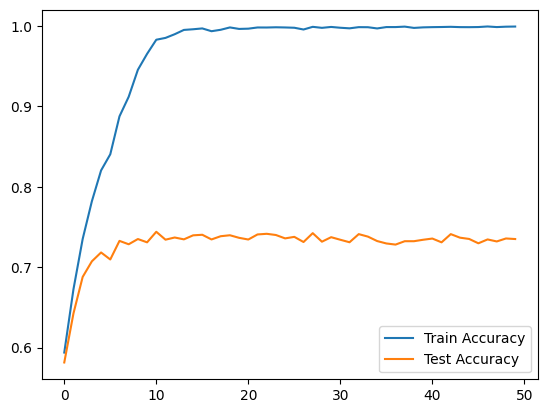

In [ ]:
# Epoch에 따른 train과 test data에 대한 model의 정확도를 plot합니다
plot_acc(train_accs_Adam, test_accs_Adam, label1='Train Accuracy', label2='Test Accuracy')

##[Feedback] Adam Test
Taining 데이터 곡선이 가파롭고 훈련이 10에서부터 는 9.8에 가까운데 overfit 된 의심이 듭니다.
Test 는 역시 10으로 부터 정확도가 7.3가깝게 되고 더이상 개선이 보이지 않았습니다.

In [12]:
train_accs_SGD,test_accs_SGD =  training(50,"Leaky_Relu", "SGD")

act_type: Leaky_Relu
SGD  training:
Epoch   0 | Loss: 450.72083592414856 | train_acc: 0.10424 | test_acc: 0.104
Epoch   1 | Loss: 449.2220530509949 | train_acc: 0.1473 | test_acc: 0.14
Epoch   2 | Loss: 447.64548110961914 | train_acc: 0.17762 | test_acc: 0.1696
Epoch   3 | Loss: 445.8290231227875 | train_acc: 0.2116 | test_acc: 0.2072
Epoch   4 | Loss: 443.5383687019348 | train_acc: 0.23808 | test_acc: 0.2388
Epoch   5 | Loss: 440.7007145881653 | train_acc: 0.24976 | test_acc: 0.2538
Epoch   6 | Loss: 437.1986575126648 | train_acc: 0.25404 | test_acc: 0.2601
Epoch   7 | Loss: 432.8500130176544 | train_acc: 0.25438 | test_acc: 0.2637
Epoch   8 | Loss: 427.86230754852295 | train_acc: 0.25724 | test_acc: 0.2659
Epoch   9 | Loss: 422.35147309303284 | train_acc: 0.26024 | test_acc: 0.2689
Epoch  10 | Loss: 416.82310009002686 | train_acc: 0.2651 | test_acc: 0.2724
Epoch  11 | Loss: 411.44234347343445 | train_acc: 0.27102 | test_acc: 0.2775
Epoch  12 | Loss: 406.5532305240631 | train_acc: 0.2

In [13]:
Model_Relu_SGD = model

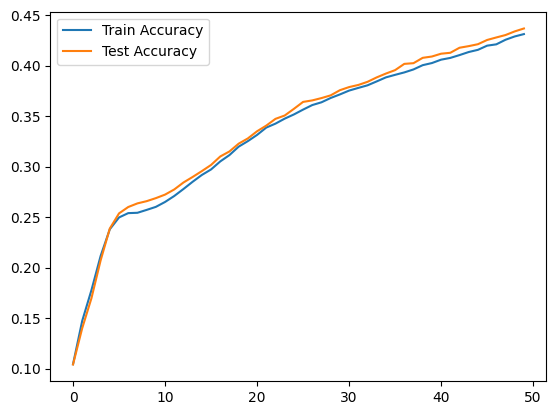

In [14]:
plot_acc(train_accs_SGD, test_accs_SGD, label1='Train Accuracy', label2='Test Accuracy')

#[Feedback] SGD Test
1.SGD 이 Adam 로 사용한 결과보다 곡선이 더욱 smooth 합니다.
2.정확도는 낮습니다. SGD 보다 낮습니다,  하지만 배치수량을 늘이면 더 나아질것 같습니다.
3.Taining 결과와 Test 결과가 기본적으로 일치한것을 볼수가 있습니다.

In [45]:
train_accs_SGD_Sigmoid,test_accs_SGD_Sigmoid =  training(10, "Sigmoid", "SGD")

act_type: Sigmoid
SGD  training:
Epoch   0 | Loss: 451.7858655452728 | train_acc: 0.1 | test_acc: 0.1
Epoch   1 | Loss: 451.6504089832306 | train_acc: 0.1 | test_acc: 0.1
Epoch   2 | Loss: 451.55058097839355 | train_acc: 0.1 | test_acc: 0.1
Epoch   3 | Loss: 451.4714460372925 | train_acc: 0.1 | test_acc: 0.1
Epoch   4 | Loss: 451.42859530448914 | train_acc: 0.1 | test_acc: 0.1
Epoch   5 | Loss: 451.3960416316986 | train_acc: 0.1 | test_acc: 0.1
Epoch   6 | Loss: 451.36678099632263 | train_acc: 0.1 | test_acc: 0.1
Epoch   7 | Loss: 451.35340785980225 | train_acc: 0.1 | test_acc: 0.1
Epoch   8 | Loss: 451.33711433410645 | train_acc: 0.1 | test_acc: 0.1
Epoch   9 | Loss: 451.32869505882263 | train_acc: 0.1 | test_acc: 0.1


##[Feedback]
Sigmoid 로서 training 하면서 얻은 결과는 0.1 가까이로 계속나오고 계선이 되지않아 어딘가 잘못되였다고 생각했습니다.  
검색을 해보니 CNN 모델에는 Sigmoid 이 적합하지 않다고 나옵니다.
이 결론에 대해 코칭님의 멘토링을 받고 싶습니다.

GPU 환경문제와 시간상 관계로 Sigmoid 50까지 돌리지 못하고 또한 결과값의 이상으로 배치 10번만 돌리고 올리기로 했습니다.

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

##[FEEDBACK]
모델 배포한 상태에서 예측값을 직관으로 비교하고 보기 위한 코드 입니다. 위에서 Relu 대한 훈련결과의 모델을 사용한 결과, 정확도는 높지 않았습니다.

In [21]:
def lb_check(idx, Model):
  x = trainset[idx][0][None]  # (1, 1, 28, 28)
  x = x.to(device)

  model = Model_Relu_SGD
  logits = model(x)

  print(logits)
  print("오리지널 데이터:",trainset[idx][1])
  predicted_class = torch.argmax(logits, dim=1).item()
  print("모델추출 데이터: ",predicted_class)

  print("--------------------")

  print(len(trainset))
  print(trainset[0][0].shape, trainset[0][1])
  plt.imshow(trainset[idx][0][0], cmap='gray')

  print("--------------------")

  def switch_label(index):
      if index == 0:
          return "airplane"
      elif index == 1:
          return "automobile"
      elif index == 2:
          return "bird"
      elif index == 3:
          return "cat"
      elif index == 4:
          return "deer"
      elif index == 5:
          return "dog"
      elif index == 6:
          return "frog"
      elif index == 7:
          return "horse"
      elif index == 8:
          return "ship"
      elif index == 9:
          return "truck"
      else:
          return "Unknown"

  label_index = trainset[idx][1]

  label_name = switch_label(label_index)
  predict_name = switch_label(predicted_class)

  print(f"Correct index: {label_index}")
  print(f"Correct name: {label_name}")
  print(f"Predict name: {predict_name}")


tensor([[ 0.0527,  0.0432, -0.0024,  0.0856,  0.0619, -0.0015,  0.0867,  0.0343,
          0.0221,  0.0063]], device='cuda:0', grad_fn=<AddmmBackward0>)
오리지널 데이터: 6
모델추출 데이터:  6
--------------------
50000
torch.Size([3, 32, 32]) 6
--------------------
Correct index: 6
Correct name: frog
Predict name: frog


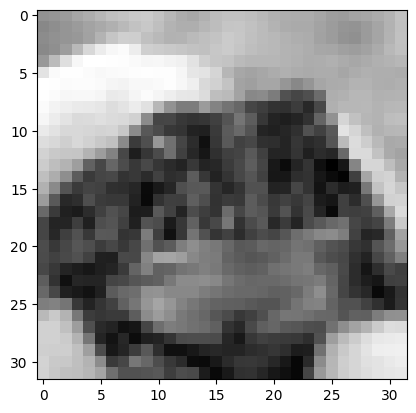

In [53]:
model = Model_Relu_SGD.to(device)
lb_check(25,model)

여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.